Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.69106 154.776; 7.85694 154.473; … ; 7.9259 154.434; 7.9107 155.183]

Union{Missing, Float64}[7.45684 155.034; 7.7026 154.275; … ; 7.73695 155.197; 7.64069 154.625]

Union{Missing, Float64}[7.90241 154.395; 7.89925 154.935; … ; 8.11452 155.092; 7.43025 155.123]

Union{Missing, Float64}[8.31485 154.889; 8.09642 154.993; … ; 7.67095 154.846; 7.53506 154.743]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD       Naive SE       MCSE      ESS
sigma   7.7765628 0.29135254 0.0046066882 0.0064077571 1000
   mu 154.6145142 0.42239426 0.0066786397 0.0065664437 1000

Quantiles:
          2.5%       25.0%       50.0%     75.0%      97.5%  
sigma   7.2312773   7.5731475   7.767675   7.96684   8.372699
   mu 153.8079500 154.3180000 154.621500 154.90600 155.425125



Plot the density of posterior draws

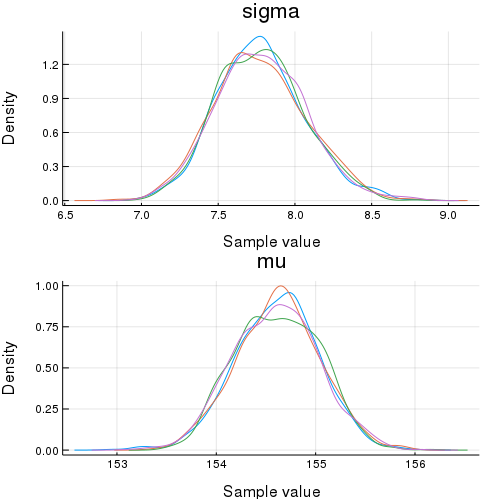

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.17638629004904896
 0.08243281890729891

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0402489
 0.0402489  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*